In [ ]:
# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

!pip install findspark

import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
#spark = SparkSession.builder.master("local[4]")  # this creates spark session to  run locally, the braket[] means number of cores 



In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark ML basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#raw_data = spark.read.format("csv").option("header","true").option("inferSchema", "true").load(r".\\diabetes.csv")
dataset = spark.read.csv('drive/My Drive/Colab Notebooks/Files/diabetes.csv',inferSchema=True, header =True)

In [ ]:
dataset.columns

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Outcome']

In [ ]:
dataset.describe().select("Summary","Pregnancies","Glucose","BloodPressure").show()

+-------+------------------+-----------------+------------------+
|Summary|       Pregnancies|          Glucose|     BloodPressure|
+-------+------------------+-----------------+------------------+
|  count|               768|              768|               768|
|   mean|3.8450520833333335|     120.89453125|       69.10546875|
| stddev|  3.36957806269887|31.97261819513622|19.355807170644777|
|    min|                 0|                0|                 0|
|    max|                17|              199|               122|
+-------+------------------+-----------------+------------------+



In [ ]:
dataset.describe().select("Summary","SkinThickness","Insulin").show()

+-------+------------------+------------------+
|Summary|     SkinThickness|           Insulin|
+-------+------------------+------------------+
|  count|               768|               768|
|   mean|20.536458333333332| 79.79947916666667|
| stddev|15.952217567727642|115.24400235133803|
|    min|                 0|                 0|
|    max|                99|               846|
+-------+------------------+------------------+



In [ ]:
dataset.describe().select("Summary","BMI","DiabetesPedigreeFunction","Age").show()

+-------+------------------+------------------------+------------------+
|Summary|               BMI|DiabetesPedigreeFunction|               Age|
+-------+------------------+------------------------+------------------+
|  count|               768|                     768|               768|
|   mean|31.992578124999977|      0.4718763020833327|33.240885416666664|
| stddev| 7.884160320375441|       0.331328595012775|11.760231540678689|
|    min|               0.0|                   0.078|                21|
|    max|              67.1|                    2.42|                81|
+-------+------------------+------------------------+------------------+



In [ ]:
# replace min value of zeros with Nan as data cleaning processs
import numpy as np
from pyspark.sql.functions import when
dataset=dataset.withColumn("Glucose",when(dataset.Glucose==0,np.nan).otherwise (dataset.Glucose))
dataset=dataset.withColumn("BloodPressure",when(dataset.BloodPressure==0,np.nan).otherwise(dataset.BloodPressure))
dataset=dataset.withColumn("SkinThickness",when(dataset.SkinThickness==0,np.nan).otherwise(dataset.SkinThickness))
dataset=dataset.withColumn("BMI",when(dataset.BMI==0,np.nan).otherwise(dataset.BMI))
dataset=dataset.withColumn("Insulin",when(dataset.Insulin==0,np.nan).otherwise(dataset.Insulin))
dataset.select("Insulin","Glucose","BloodPressure","SkinThickness","BMI").show(5)


+-------+-------+-------------+-------------+----+
|Insulin|Glucose|BloodPressure|SkinThickness| BMI|
+-------+-------+-------------+-------------+----+
|    NaN|  148.0|         72.0|         35.0|33.6|
|    NaN|   85.0|         66.0|         29.0|26.6|
|    NaN|  183.0|         64.0|          NaN|23.3|
|   94.0|   89.0|         66.0|         23.0|28.1|
|  168.0|  137.0|         40.0|         35.0|43.1|
+-------+-------+-------------+-------------+----+
only showing top 5 rows



In [ ]:
#impute
from pyspark.ml.feature import Imputer
imputer=Imputer(inputCols=["Glucose","BloodPressure","SkinThickness","BMI","Insulin"],outputCols=["Glucose","BloodPressure","SkinThickness","BMI","Insulin"])
model=imputer.fit(dataset)
dataset=model.transform(dataset)
dataset.show(5)

+-----------+-------+-------------+------------------+-----------------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|     SkinThickness|          Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+------------------+-----------------+----+------------------------+---+-------+
|          6|  148.0|         72.0|              35.0|155.5482233502538|33.6|                   0.627| 50|      1|
|          1|   85.0|         66.0|              29.0|155.5482233502538|26.6|                   0.351| 31|      0|
|          8|  183.0|         64.0|29.153419593345657|155.5482233502538|23.3|                   0.672| 32|      1|
|          1|   89.0|         66.0|              23.0|             94.0|28.1|                   0.167| 21|      0|
|          0|  137.0|         40.0|              35.0|            168.0|43.1|                   2.288| 33|      1|
+-----------+-------+-------------+------------------+-----------------+----+---

In [ ]:
#us combine all the features in one single feature vector.
cols=dataset.columns
cols.remove("Outcome")
# Let us import the vector assembler
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=cols,outputCol="features")
# Now let us use the transform method to transform our dataset
dataset=assembler.transform(dataset)
dataset.select("features").show(truncate=False)

+-----------------------------------------------------------------------------------+
|features                                                                           |
+-----------------------------------------------------------------------------------+
|[6.0,148.0,72.0,35.0,155.5482233502538,33.6,0.627,50.0]                            |
|[1.0,85.0,66.0,29.0,155.5482233502538,26.6,0.351,31.0]                             |
|[8.0,183.0,64.0,29.153419593345657,155.5482233502538,23.3,0.672,32.0]              |
|[1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0]                                          |
|[0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0]                                        |
|[5.0,116.0,74.0,29.153419593345657,155.5482233502538,25.6,0.201,30.0]              |
|[3.0,78.0,50.0,32.0,88.0,31.0,0.248,26.0]                                          |
|[10.0,115.0,72.40518417462484,29.153419593345657,155.5482233502538,35.3,0.134,29.0]|
|[2.0,197.0,70.0,45.0,543.0,30.5,0.158,53.0]          

In [ ]:
#Standard Sclarizer
from pyspark.ml.feature import StandardScaler
standardscaler=StandardScaler().setInputCol("features").setOutputCol("Scaled_features")
dataset=standardscaler.fit(dataset).transform(dataset)
dataset.select("features","Scaled_features").show(5)

+--------------------+--------------------+
|            features|     Scaled_features|
+--------------------+--------------------+
|[6.0,148.0,72.0,3...|[1.78063837321943...|
|[1.0,85.0,66.0,29...|[0.29677306220323...|
|[8.0,183.0,64.0,2...|[2.37418449762590...|
|[1.0,89.0,66.0,23...|[0.29677306220323...|
|[0.0,137.0,40.0,3...|[0.0,4.5012560836...|
+--------------------+--------------------+
only showing top 5 rows



In [ ]:
#Train, test split
train, test = dataset.randomSplit([0.8, 0.2], seed=12345)

In [ ]:
#Feature selection
# Feature selection using chisquareSelector
from pyspark.ml.feature import ChiSqSelector
#css = ChiSqSelector(featuresCol='Scaled_features',outputCol='Aspect1',labelCol='Outcome',fpr=0.03) # whose p-value is lower than some threshold
css1 = ChiSqSelector(featuresCol='Scaled_features',outputCol='Aspect1',labelCol='Outcome',numTopFeatures = 1)
train=css1.fit(train).transform(train)
test=css1.fit(test).transform(test)
test.select("Aspect1").show(10,truncate=False)


css2 = ChiSqSelector(featuresCol='Scaled_features',outputCol='Aspect2',labelCol='Outcome',numTopFeatures = 2)
train=css2.fit(train).transform(train)
test=css2.fit(test).transform(test)
test.select("Aspect2").show(10,truncate=False)

css3 = ChiSqSelector(featuresCol='Scaled_features',outputCol='Aspect3',labelCol='Outcome',numTopFeatures = 3)
train=css3.fit(train).transform(train)
test=css3.fit(test).transform(test)
test.select("Aspect3").show(10,truncate=False)


# Imp Arguments
# numTopFeatures chooses a fixed number of top features according to a chi-squared test. This is akin to yielding the features with the most predictive power.
# percentile is similar to numTopFeatures but chooses a fraction of all features instead of a fixed number.
# fpr chooses all features whose p-values are below a threshold, thus controlling the false positive rate of selection.
# By default, the selection method is numTopFeatures, with the default number of top features set to 50. The user can choose a selection method using setSelectorType.



#####################
# Tutorial
#####################
# Find methods to apply other feature selection algorithms.
# FOr example, PCA, SVD, etc
# Apply at-least one more algorithm for feature selection apart from Chi^2 algorithm and show results to your tutor 


+-------+
|Aspect1|
+-------+
|[0.0]  |
|[0.0]  |
|[0.0]  |
|[0.0]  |
|[0.0]  |
|[0.0]  |
|[0.0]  |
|[0.0]  |
|[0.0]  |
|[0.0]  |
+-------+
only showing top 10 rows

+------------------------+
|Aspect2                 |
+------------------------+
|[0.0,2.7598942410664704]|
|[0.0,3.3184442660442084]|
|[0.0,3.3184442660442084]|
|[0.0,3.3513001498664283]|
|[0.0,3.449867801333088] |
|[0.0,3.712714871910847] |
|[0.0,3.8441384071997264]|
|[0.0,4.172697245421926] |
|[0.0,4.961238457155202] |
|[0.0,5.322653179199621] |
+------------------------+
only showing top 10 rows

+------------------------------------------+
|Aspect3                                   |
+------------------------------------------+
|[0.0,2.7598942410664704,1.955743806611537]|
|[0.0,3.3184442660442084,1.785679127775751]|
|[0.0,3.3184442660442084,1.870711467193644]|
|[0.0,3.3513001498664283,1.785679127775751]|
|[0.0,3.449867801333088,1.870711467193644] |
|[0.0,3.712714871910847,1.785679127775751] |
|[0.0,3.8441384071997264,

In [ ]:
#Building a classification model using Logistic Regression (LR)
from pyspark.ml.classification import LogisticRegression
lr1 = LogisticRegression(labelCol="Outcome", featuresCol="Aspect1",maxIter=10)
model1=lr1.fit(train)
predict_train1=model1.transform(train)
predict_test1=model1.transform(test)
predict_test1.select("Outcome","prediction").show(10)


lr2 = LogisticRegression(labelCol="Outcome", featuresCol="Aspect2",maxIter=10)
model2=lr2.fit(train)
predict_train2=model2.transform(train)
predict_test2=model2.transform(test)
predict_test2.select("Outcome","prediction").show(10)

lr3 = LogisticRegression(labelCol="Outcome", featuresCol="Aspect3",maxIter=10)
model3=lr.fit(train)
predict_train3=model3.transform(train)
predict_test3=model3.transform(test)
predict_test3.select("Outcome","prediction").show(10)

+-------+----------+
|Outcome|prediction|
+-------+----------+
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      1|       0.0|
|      1|       0.0|
+-------+----------+
only showing top 10 rows

+-------+----------+
|Outcome|prediction|
+-------+----------+
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      1|       0.0|
|      1|       0.0|
+-------+----------+
only showing top 10 rows

+-------+----------+
|Outcome|prediction|
+-------+----------+
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      1|       0.0|
|      1|       0.0|
+-------+----------+
only showing top 10 rows



In [ ]:
trainingSummary1 = model1.summary

trainingSummary2 = model2.summary

trainingSummary3 = model3.summary



In [ ]:
#Evaluating the model
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator=BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol="Outcome")
predict_test1.select("Outcome","rawPrediction","prediction","probability").show(5)

+-------+--------------------+----------+--------------------+
|Outcome|       rawPrediction|prediction|         probability|
+-------+--------------------+----------+--------------------+
|      0|[2.16973615977257...|       0.0|[0.89749869717612...|
|      0|[2.16973615977257...|       0.0|[0.89749869717612...|
|      0|[2.16973615977257...|       0.0|[0.89749869717612...|
|      0|[2.16973615977257...|       0.0|[0.89749869717612...|
|      0|[2.16973615977257...|       0.0|[0.89749869717612...|
+-------+--------------------+----------+--------------------+
only showing top 5 rows



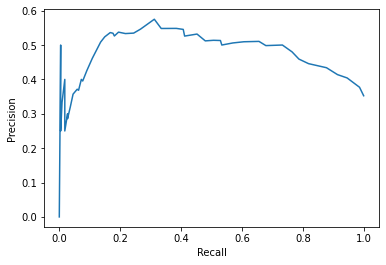

In [ ]:
print(model.summary)
import matplotlib.pyplot as plt
pr = model1.summary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [ ]:
accuracy_model_1 = trainingSummary1.accuracy
print('acuracy_model_1 = ', accuracy_model_1)

accuracy_model_2 = trainingSummary2.accuracy
print('acuracy_model_2 = ', accuracy_model_2)

accuracy_model_3 = trainingSummary3.accuracy
print('acuracy_model_3 = ', accuracy_model_3)



acuracy_model_1 =  0.6570972886762361
acuracy_model_1 =  0.6570972886762361
acuracy_model_1 =  0.6570972886762361


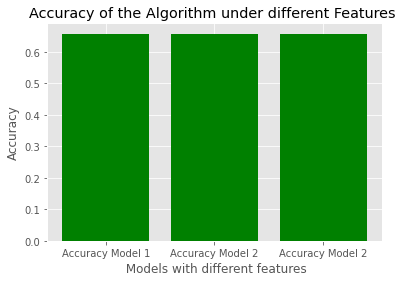

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

x = ['Accuracy Model 1', 'Accuracy Model 2', 'Accuracy Model 2']
accuracy = [accuracy_model_1, accuracy_model_2, accuracy_model_3]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, accuracy, color='green')
plt.xlabel(" Models with different features")
plt.ylabel("Accuracy")
plt.title("Accuracy of the Algorithm under different Features ")

plt.xticks(x_pos, x)

plt.show()